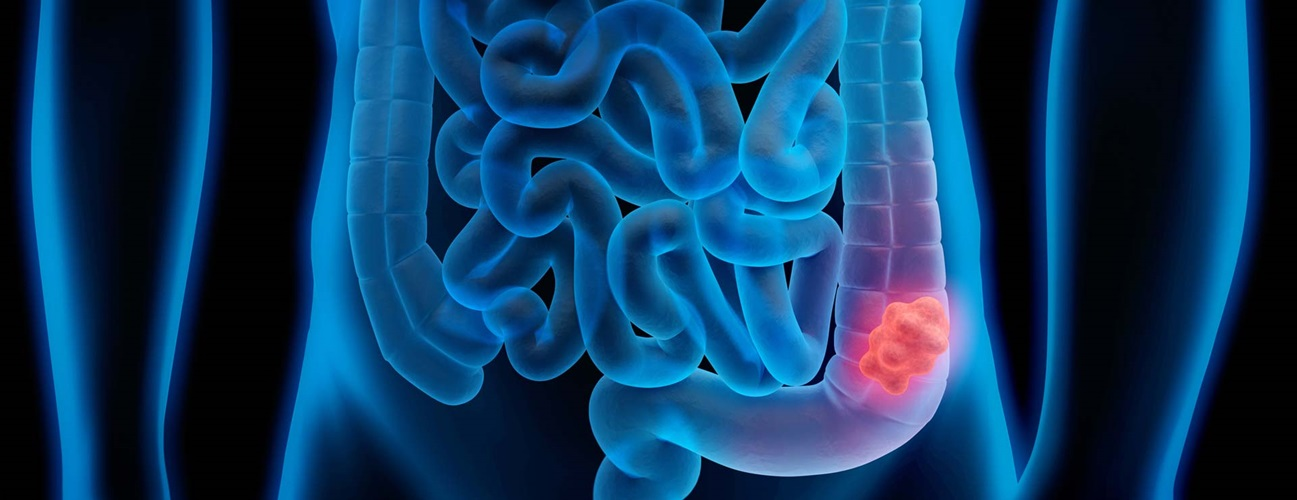

## About the data 

Folder colon_image_sets contains two secondary subfolders: colon_aca subfolder with 5000 images of colon adenocarcinomas and colon_n subfolder with 5000 images of benign colonic tissues.

## Importing libraries

In [ ]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import seaborn as sns
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
import tensorflow as ts 
from  tensorflow import keras
import itertools
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

# Data loading and exploring

In [ ]:
data_dir = "/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets"
colon = os.listdir(data_dir)

In [ ]:
colon

['colon_aca', 'colon_n']

In [ ]:
# Number of images for each disease
nums_train = {}
for col in colon:
    nums_train[col] = len(os.listdir(data_dir + '/' + col))
img_per_class_train = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["no. of images"])
print('Train data distribution :')
img_per_class_train

Train data distribution :


,no. of images
colon_aca,5000
colon_n,5000


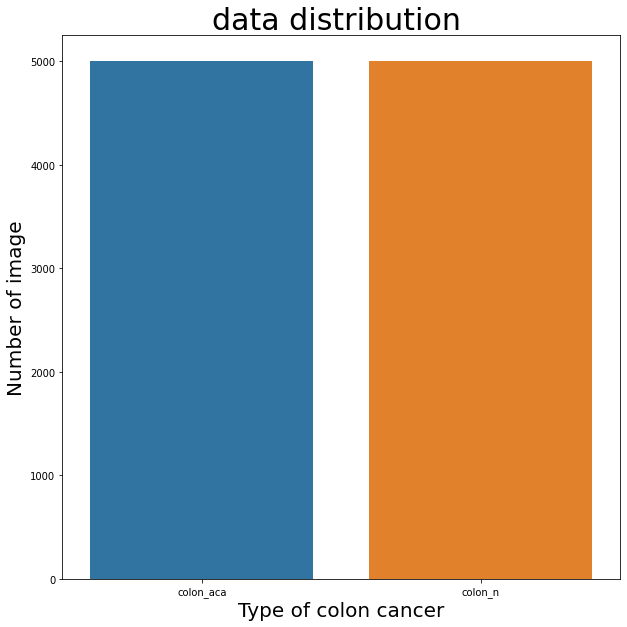

In [ ]:
plt.figure(figsize=(10,10))
plt.title('data distribution ',fontsize=30)
plt.ylabel('Number of image',fontsize=20)
plt.xlabel('Type of colon cancer',fontsize=20)

keys = list(nums_train.keys())
# get values in the same order as keys, and parse percentage values
vals = list(nums_train.values())
sns.barplot(x=keys, y=vals)


# Show some example for colon cancer

In [ ]:
# Function to show image
train = ImageFolder(data_dir, transform=transforms.ToTensor())
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    return image.permute(1, 2, 0)

## Colon_aca

Label :colon_aca(0)
Label :colon_aca(0)
Label :colon_aca(0)
Label :colon_aca(0)
Label :colon_aca(0)
Label :colon_aca(0)


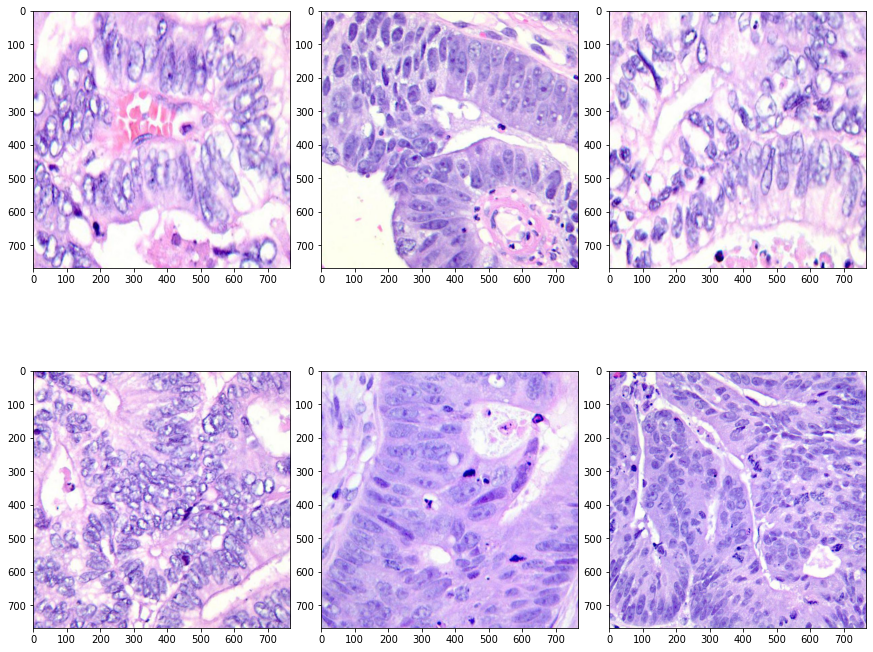

In [ ]:
fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*train[1]))
axs[0,1].imshow(show_image(*train[5]))
axs[1, 0].imshow(show_image(*train[6]))
axs[1,1].imshow(show_image(*train[10]))
axs[0,2].imshow(show_image(*train[20]))
axs[1,2].imshow(show_image(*train[30]))

## Colon_n

Label :colon_n(1)
Label :colon_n(1)
Label :colon_n(1)
Label :colon_n(1)
Label :colon_n(1)
Label :colon_n(1)


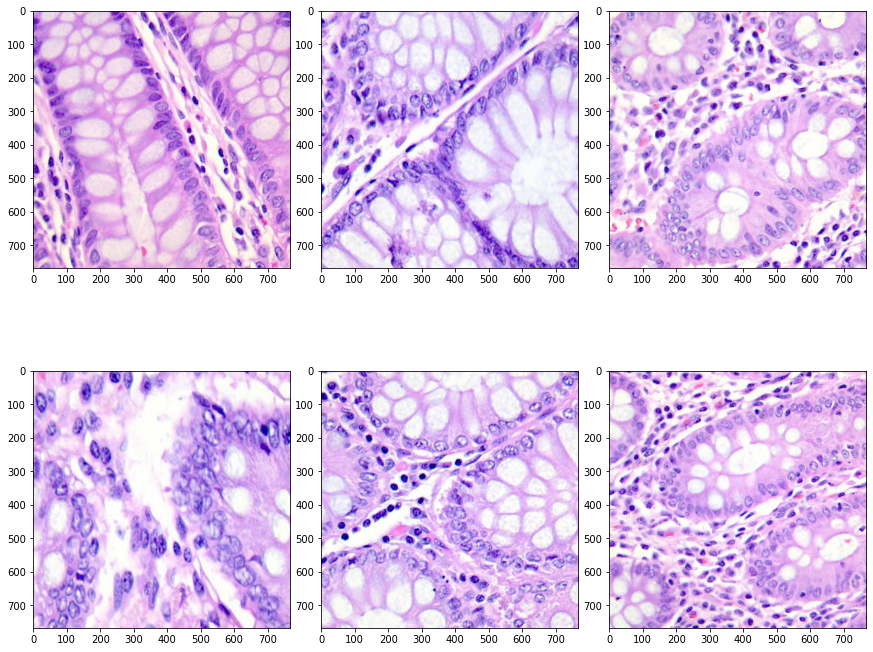

In [ ]:
fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*train[5005]))
axs[0,1].imshow(show_image(*train[5010]))
axs[1, 0].imshow(show_image(*train[6000]))
axs[1,1].imshow(show_image(*train[6001]))
axs[0,2].imshow(show_image(*train[7000]))
axs[1,2].imshow(show_image(*train[7020]))

# Modeling

In [ ]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                         rotation_range = 20 ,
                                                         horizontal_flip = True ,
                                                         validation_split = 0.25
                                                         )
valid_gen =  keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split = 0.25)
train_data = train_gen.flow_from_directory(data_dir, subset='training', target_size=(224,224), batch_size=64, color_mode='rgb', 
                                            class_mode='categorical', shuffle=True)

val_data = valid_gen.flow_from_directory(data_dir, subset='validation', target_size=(224,224), batch_size=64, color_mode='rgb', 
                                            class_mode='categorical', shuffle=False)

Found 7500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [ ]:
import numpy
unique, counts = numpy.unique(val_data.classes, return_counts=True)

dict(zip(unique, counts))

{0: 1250, 1: 1250}

## Model_1


In [ ]:
model_1 = keras.models.Sequential()

model_1.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))

model_1.add(keras.layers.Dropout(0.1))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Conv2D(64, 3, activation='relu'))
model_1.add(keras.layers.Dropout(0.2))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Flatten())
model_1.add(keras.layers.Dense(128, activation='relu'))
model_1.add(keras.layers.Dense(2, activation='softmax'))

model_1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 dropout (Dropout)           (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 dropout_1 (Dropout)         (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                    

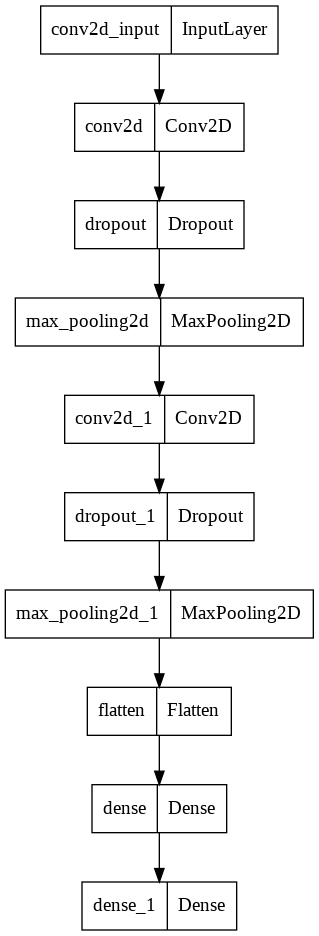

In [ ]:
keras.utils.plot_model(
    model_1,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [ ]:
history = model_1.fit_generator(train_data,
          validation_data=val_data,
          epochs = 10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
118/118 [==============================] - 161s 1s/step - loss: 1.1625 - accuracy: 0.6411 - val_loss: 0.4319 - val_accuracy: 0.8568
Epoch 2/10
118/118 [==============================] - 150s 1s/step - loss: 0.3749 - accuracy: 0.8319 - val_loss: 0.3987 - val_accuracy: 0.8316
Epoch 3/10
118/118 [==============================] - 169s 1s/step - loss: 0.3024 - accuracy: 0.8709 - val_loss: 0.5493 - val_accuracy: 0.7192
Epoch 4/10
118/118 [==============================] - 150s 1s/step - loss: 0.2702 - accuracy: 0.8904 - val_loss: 0.4105 - val_accuracy: 0.8272
Epoch 5/10
118/118 [==============================] - 148s 1s/step - loss: 0.2363 - accuracy: 0.9028 - val_loss: 0.2985 - val_accuracy: 0.8784
Epoch 6/10
118/118 [==============================] - 147s 1s/step - loss: 0.2359 - accuracy: 0.8996 - val_loss: 0.3114 - val_accuracy: 0.8720
Epoch 7/10
118/118 [==============================] - 148s 1s/step - loss: 0.2042 - accuracy: 0.9167 - val_loss: 0.1870 - val_accuracy: 0.9304

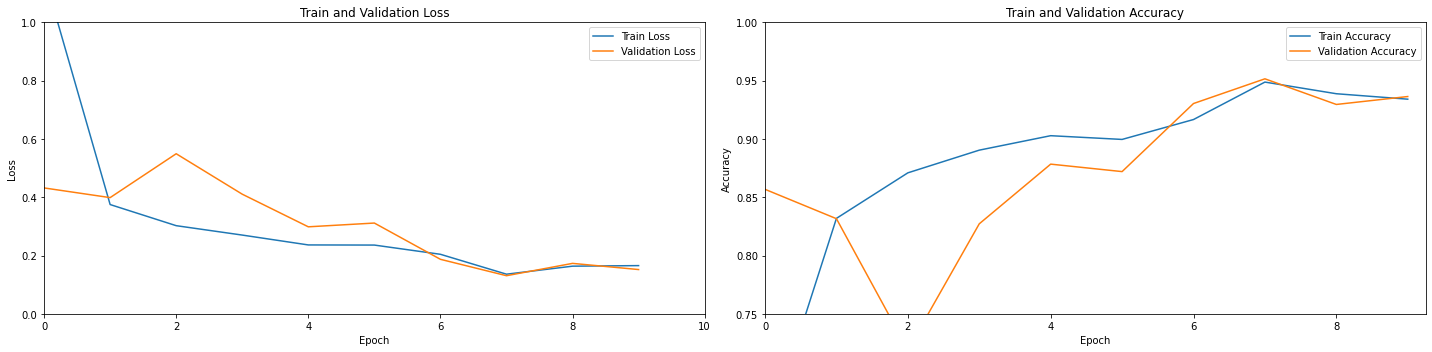

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [ ]:
from sklearn.metrics import classification_report

Y_pred = model_1.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(val_data.classes, y_pred))

40/40 [==============================] - 20s 507ms/step
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1250
           1       0.92      0.96      0.94      1250

    accuracy                           0.94      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500



## Model_2

In [ ]:
model_2 = keras.models.Sequential()

model_2.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))
model_2.add(keras.layers.MaxPooling2D())

model_2.add(keras.layers.Conv2D(64, 3, activation='relu'))
model_2.add(keras.layers.MaxPooling2D())

model_2.add(keras.layers.Flatten())
model_2.add(keras.layers.Dense(128, activation='relu'))
model_2.add(keras.layers.Dense(2, activation='softmax'))

model_2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

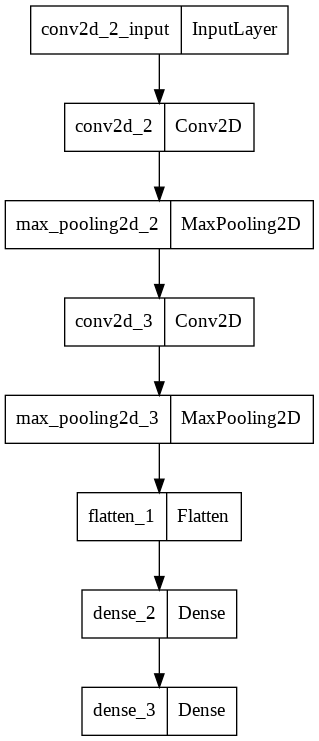

In [ ]:
keras.utils.plot_model(
    model_2,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [ ]:
history = model_2.fit_generator(train_data,
          validation_data=val_data,
          epochs = 10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
118/118 [==============================] - 149s 1s/step - loss: 1.3124 - accuracy: 0.5657 - val_loss: 0.6972 - val_accuracy: 0.5032
Epoch 2/10
118/118 [==============================] - 168s 1s/step - loss: 0.5795 - accuracy: 0.7189 - val_loss: 0.4514 - val_accuracy: 0.8212
Epoch 3/10
118/118 [==============================] - 148s 1s/step - loss: 0.4508 - accuracy: 0.8033 - val_loss: 0.4393 - val_accuracy: 0.7956
Epoch 4/10
118/118 [==============================] - 153s 1s/step - loss: 0.3881 - accuracy: 0.8399 - val_loss: 0.3387 - val_accuracy: 0.8680
Epoch 5/10
118/118 [==============================] - 148s 1s/step - loss: 0.3541 - accuracy: 0.8580 - val_loss: 0.3044 - val_accuracy: 0.8804
Epoch 6/10
118/118 [==============================] - 147s 1s/step - loss: 0.3162 - accuracy: 0.8741 - val_loss: 0.3496 - val_accuracy: 0.8604
Epoch 7/10
118/118 [==============================] - 148s 1s/step - loss: 0.2897 - accuracy: 0.8884 - val_loss: 0.2989 - val_accuracy: 0.8840

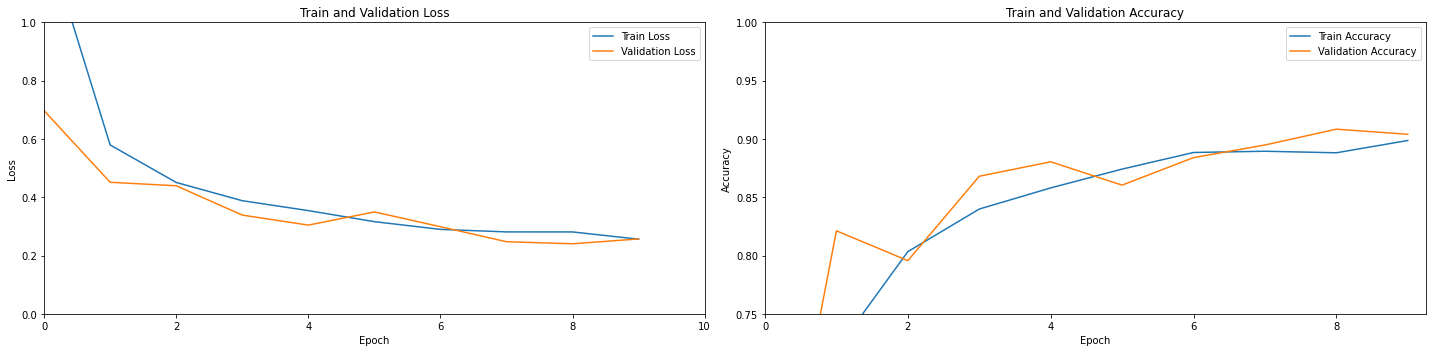

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [ ]:
Y_pred = model_2.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(val_data.classes, y_pred))

40/40 [==============================] - 21s 520ms/step
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1250
           1       0.95      0.85      0.90      1250

    accuracy                           0.90      2500
   macro avg       0.91      0.90      0.90      2500
weighted avg       0.91      0.90      0.90      2500



## Model_3

In [ ]:
model_3 = keras.Sequential()

model_3.add(keras.layers.Conv2D(32,(3,3),activation="relu",padding="same",input_shape=(224,224,3)))
model_3.add(keras.layers.Conv2D(32,(3,3),activation="relu",padding="same"))
model_3.add(keras.layers.MaxPooling2D(3,3))

model_3.add(keras.layers.Conv2D(64,(3,3),activation="relu",padding="same"))
model_3.add(keras.layers.Conv2D(64,(3,3),activation="relu",padding="same"))
model_3.add(keras.layers.MaxPooling2D(3,3))

model_3.add(keras.layers.Conv2D(128,(3,3),activation="relu",padding="same"))
model_3.add(keras.layers.Conv2D(128,(3,3),activation="relu",padding="same"))
model_3.add(keras.layers.MaxPooling2D(3,3))

model_3.add(keras.layers.Flatten())

model_3.add(keras.layers.Dense(512,activation="relu"))
model_3.add(keras.layers.Dropout(0.5))

model_3.add(keras.layers.Dense(2,activation="softmax"))

opt = keras.optimizers.Adam(learning_rate=0.0001)
model_3.compile(optimizer=opt,loss="categorical_crossentropy",metrics=['accuracy'])
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 74, 74, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 74, 74, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                  

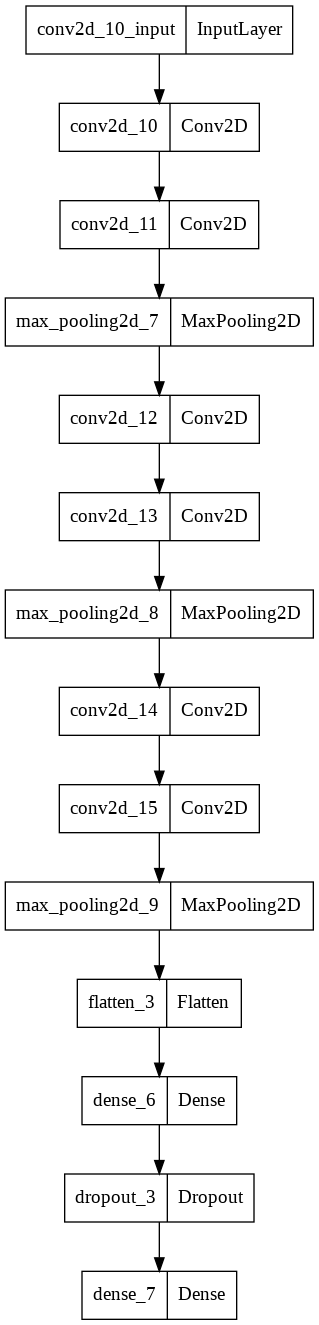

In [ ]:
keras.utils.plot_model(
    model_3,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [ ]:
history = model_3.fit_generator(train_data,
          validation_data=val_data,
          epochs = 10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
118/118 [==============================] - 153s 1s/step - loss: 0.6776 - accuracy: 0.5669 - val_loss: 0.5720 - val_accuracy: 0.8040
Epoch 2/10
118/118 [==============================] - 151s 1s/step - loss: 0.4433 - accuracy: 0.7976 - val_loss: 0.3326 - val_accuracy: 0.8584
Epoch 3/10
118/118 [==============================] - 153s 1s/step - loss: 0.2932 - accuracy: 0.8809 - val_loss: 0.2272 - val_accuracy: 0.9104
Epoch 4/10
118/118 [==============================] - 154s 1s/step - loss: 0.2301 - accuracy: 0.9032 - val_loss: 0.2873 - val_accuracy: 0.8748
Epoch 5/10
118/118 [==============================] - 155s 1s/step - loss: 0.1869 - accuracy: 0.9281 - val_loss: 0.1191 - val_accuracy: 0.9508
Epoch 6/10
118/118 [==============================] - 159s 1s/step - loss: 0.1454 - accuracy: 0.9428 - val_loss: 0.0981 - val_accuracy: 0.9612
Epoch 7/10
118/118 [==============================] - 154s 1s/step - loss: 0.1256 - accuracy: 0.9529 - val_loss: 0.0949 - val_accuracy: 0.9604

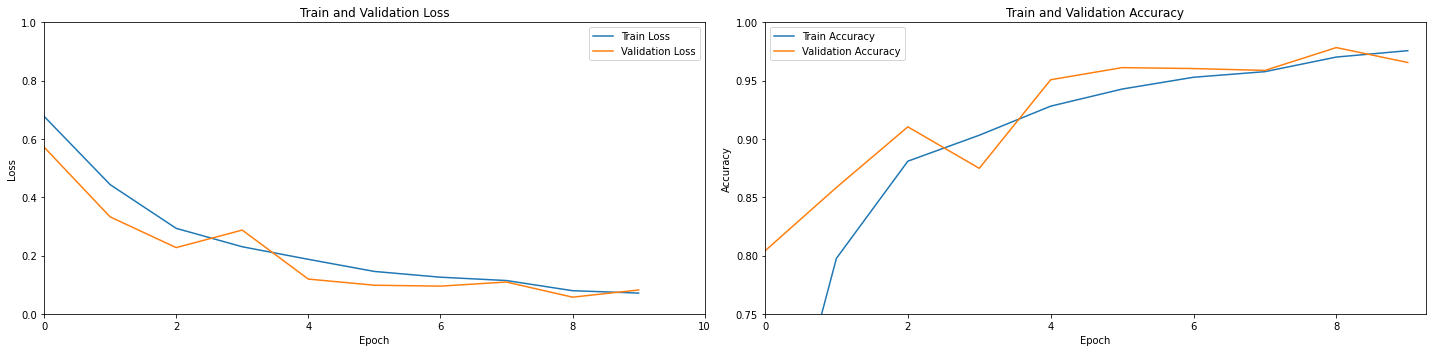

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [ ]:
from sklearn.metrics import classification_report

Y_pred = model_3.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(val_data.classes, y_pred))

40/40 [==============================] - 21s 526ms/step
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1250
           1       0.95      0.98      0.97      1250

    accuracy                           0.97      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.97      0.97      0.97      2500



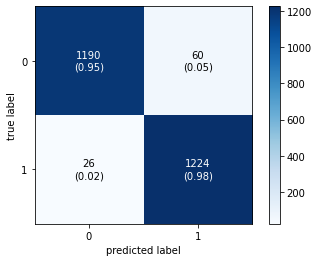

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
# calculating and plotting the confusion matrix
cm1 = confusion_matrix(val_data.classes, y_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()